In [264]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime
from pathlib import Path
import statistics

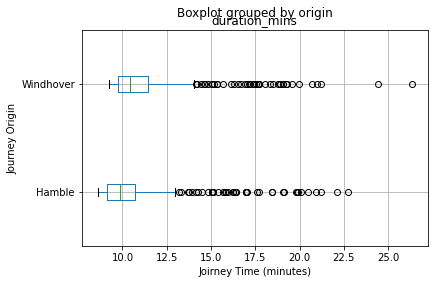

In [265]:
def render_box_plot(file_name):

    df = pd.read_csv(file_name)

    df['duration_mins'] = df['duration']/60
    df['timestamp'] = pd.to_datetime(df['timestamp'])


    #fig, ax = plt.subplots()
    
    # df.boxplot(column=df['duration_mins'], vert=False, by=df['origin']) 
    #ax.set_ylabel('Joirney Time (minutes)')
    #ax.set_xlabel('Journey Origin')
    #.figure(figsize=[16,7])
    #plt.boxplot(df['duration_mins'], by=df['origin'], vert=False)

    ax = df.boxplot(column='duration_mins', by='origin', vert=False)
    ax.set_ylabel('Journey Origin')
    ax.set_xlabel('Joirney Time (minutes)')

    plt.show()

render_box_plot('data/2023/Jan/2023-01-10.csv.gz')

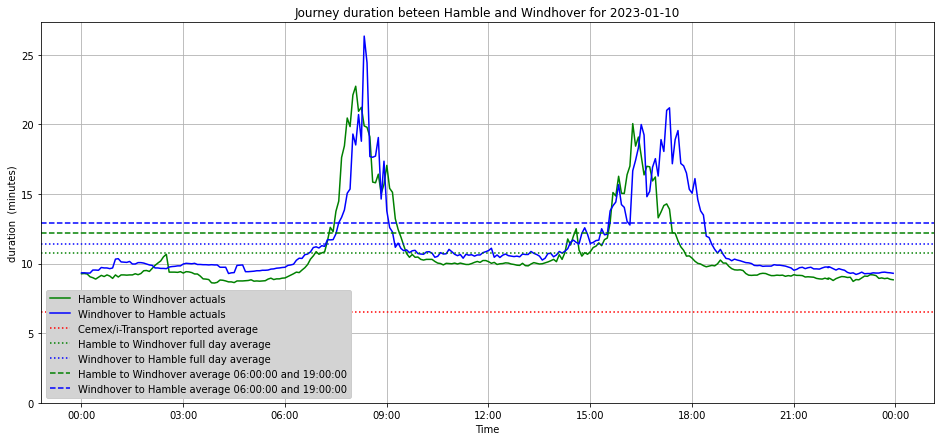

In [266]:
# Creates a chart from agiven df and saves the rendering of it
def render_time_series_chart(df_file_name, origin, dest, measure_and_unit='duration_minutes', time_groups=None, force=False):
    
    if measure_and_unit not in ['duration_minutes', 'speed_mph']:
        return

    MS_TO_MPH = 2.2369362912
    # Cemex/i-Transport average based on 34mph average speed on Hamble lane...?
    # Google api/distanceMatrix distance average by Cemex speed average 34mph
    REPORTED_MEAN_SPEED = 15.1994 # m/s

    date = datetime.strptime(os.path.basename(df_file_name).split('.')[0], '%Y-%m-%d')
    measure = measure_and_unit.split('_')[0]
    unit = measure_and_unit.split('_')[1]
    fig_name = f'{origin}-{dest}-{measure}-{str(date.date())}-ts.jpg'
    year = date.strftime('%Y')
    month = date.strftime('%b')
    
    fig_file_handle = Path('graphs/', year, month, measure, fig_name)
    fig_file_handle.parent.mkdir(exist_ok=True, parents=True)
    
    if force or (not os.path.isfile(fig_file_handle) or (os.path.isfile(fig_file_handle) and datetime.now().date() == date.date())):
        
        df = pd.read_csv(df_file_name)
        
        # Add a new column for journey time in minutes
        df['duration_minutes'] = df['duration']/60
        # Add in speed/velocity in m/s
        df['speed'] = df['distance']/df['duration']
        df['speed_mph'] = df['speed'] * MS_TO_MPH
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        #df['timestamp'] = df['timestamp'].apply( lambda t : t.time())

        df.drop(['origin_address', 'destination_address'], axis=1, inplace=True)
        df.drop(['origin_lat', 'orign_long'], axis=1, inplace=True)
        df.drop(['destination_lat', 'destination_long'], axis=1, inplace=True)
        #df.drop(['duration', 'distance'], axis=1, inplace=True)
        #df.set_index('timestamp', inplace=True)

        # Create frames for each journey type
        o2d = df.loc[(df['origin'] == origin) & (df['mode'] == 'driving')]
        d2o = df.loc[(df['origin'] == dest) & (df['mode'] == 'driving')]

        if len(o2d.index) == 0 or len(d2o.index) == 0: return

        o2d.set_index('timestamp', inplace=True)
        d2o.set_index('timestamp', inplace=True)

        plt.figure(figsize=[16,7])
        plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))

        o2d_label = f"{origin} to {dest}"
        d20_label = f"{dest} to {origin}"

        plt.plot(o2d[measure_and_unit], linestyle='solid', color="green", label=f'{o2d_label} actuals')
        plt.plot(d2o[measure_and_unit], linestyle='solid', color="blue", label=f'{d20_label} actuals')

        # Daily average
        if measure_and_unit == 'duration_minutes':
            report_average = (statistics.fmean([o2d['distance'].mean(), d2o['distance'].mean()]) / REPORTED_MEAN_SPEED) / 60
        else:
            report_average = REPORTED_MEAN_SPEED * MS_TO_MPH
        #print(report_average_mins)

        plt.axhline(y=report_average, linestyle="dotted", color='red', label=f'Cemex/i-Transport reported average') 
        plt.axhline(y=o2d[measure_and_unit].mean(), linestyle='dotted', color='green', label=f'{o2d_label} full day average')
        plt.axhline(y=d2o[measure_and_unit].mean(), linestyle='dotted', color='blue', label=f'{d20_label} full day average')

        # Actual avarages when most people are out and about and observe delays
        line_styles = ['dashed', 'dashdot']

        for index, (start_time, end_time) in enumerate(time_groups):
            if start_time is not None and end_time is not None:
                plt.axhline(
                    y=o2d.between_time(start_time, end_time).mean(numeric_only=True)[measure_and_unit], 
                    linestyle=line_styles[index], color="green", label=f'{o2d_label} average {start_time} and {end_time}')

                plt.axhline(
                    y=d2o.between_time(start_time, end_time).mean(numeric_only=True)[measure_and_unit], 
                    linestyle=line_styles[index], color="blue", label=f'{d20_label} average {start_time} and {end_time}')
        
        plt.title(f'Journey {measure} beteen {origin} and {dest} for {date.date()}')
        plt.xlabel('Time')
        plt.ylabel(f'{measure}  ({unit})')
        plt.legend()
        plt.grid()
        plt.legend(facecolor='lightgrey', framealpha=1)
        plt.gca().set_ylim(ymin=0)

        #plt.savefig(fig_file_handle, bbox_inches='tight', dpi=150)
        plt.show()

render_time_series_chart('data/2023/Jan/2023-01-10.csv.gz', 'Hamble', 'Windhover', 'duration_minutes', [('06:00:00', '19:00:00')])